# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

Assign device (GPU)

In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Training set

In [5]:
# minimum sq
sq_min = np.exp(-5)

In [6]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

In [7]:
if 0:
    sq = np.vstack((sq[0:7500,:],sq))
    target = np.vstack((target[0:7500,:],target))

In [8]:
sq.shape

(18750, 80)

In [9]:
eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

In [10]:
sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]

$Q\cdot r_\textrm{ave}$

In [11]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [12]:
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

### Test set

In [13]:
# minimum sq
sq_min = np.exp(-5)

In [14]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [15]:
sq_test.shape

(18750, 80)

In [16]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [17]:
sq_dim = sq_test.shape[1]
sample_test_dim = sq_test.shape[0]

$Q\cdot r_\textrm{ave}$

In [18]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [19]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],
                                                  fill_value='extrapolate',kind='linear')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [20]:
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [21]:
exp_scale = 6

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

## Network architecture

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [23]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load trained model

In [24]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

In [25]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x1fb5a6201f0>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x1fb59934c40>,
 '_root': <__main__.VAE at 0x1fb4929c580>}

In [26]:
model_r = reload_sm._root
#model_r.__dict__

### Loaded network architecture

In [27]:
class VAE_r():
    def __init__(self):
        self.encoder = model_r.encoder
        self.decoder = model_r.decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
M = VAE_r() # loaded model

In [28]:
def decoder_mean(model,lv):
    x = model.sample(lv)
    
    return x

def encoder_mean(model,x):
    mean = model.encode(x)[0]
    
    return mean

## Define functions 

In [29]:
exp_scale = 6

@tf.function
def f_inp_tf(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

@tf.function
def f_out_tf(predictions):
    return tf.math.exp((predictions*2-1)*exp_scale)

In [30]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [31]:
def hardsphere(q,sigma=1):
    R = to_tf(sigma/2)
    P = (3*(tf.math.sin(q*R)-q*R*tf.math.cos(q*R))/(q*R)**3)**2
    return P
    
    
def interpolation_tf(q,x,scale):
    qs = q*scale
    x_interp = tfp.math.interp_regular_1d_grid(
        to_tf(qs), tf.math.reduce_min(to_tf(q)), tf.math.reduce_max(to_tf(q)), x)
    return x_interp

def SQ_th(model, fp):
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # interpolation
    #S_interp = interpolation_tf(q,S,fp[3])
    
    return S

def IQ_th(model, fp):
    # form factor
    P = hardsphere(q,fp[3])
    
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # I(Q)
    if fit_SQ==1:
        IQ_th = S
    else:
        IQ_th = S*P
    
    # interpolation
    IQ_th_interp = interpolation_tf(q,IQ_th,fp[3])
    return IQ_th_interp

def fit_loss(model, x, fp):
    x_th = IQ_th(model, fp)
    
    # mean-square error
    err = tf.reduce_mean((tf.math.log(x_th)-tf.math.log(x))**2)
    
    return err

## Visualize the potential parameter distributions in the space of latent variables

In [32]:
x = to_tf(f_inp(sq_test_mask))
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.sample(z)
z = z.numpy()
z_mean = np.mean(z,axis=0)
zc = z-z_mean
F = zc.T

U, S, Vh = np.linalg.svd(F)

In [33]:
zs = np.matmul(zc,U)
sgn = np.ones(3)

for i in range(3):
    if np.abs(np.min(zs,axis = 0)[i]) > np.abs(np.max(zs,axis = 0)[i]):
        sgn[i] = -1
        zs[:,i] = zs[:,i]*sgn[i]

np.std(zs,axis = 0)

array([1.488865  , 0.38348514, 0.17716095], dtype=float32)

In [34]:
print(U)
print(z_mean)
print(sgn)

[[-0.7211325  -0.6927571  -0.00744578]
 [ 0.48136204 -0.50875026  0.7137673 ]
 [-0.49825546  0.5111367   0.7003433 ]]
[-0.2502039   0.484626    0.18946123]
[ 1. -1.  1.]


In [35]:
d_zs = np.max(zs,axis = 0)-np.min(zs,axis = 0)
d_z = np.max(z,axis = 0)-np.min(z,axis = 0)

In [36]:
parameters = (eta_test,kappa_test,lnA_test)
index_eta = np.arange(sq_test.shape[0])
index_slice = np.abs(zs[:,0])<0.1

In [37]:
# %matplotlib notebook

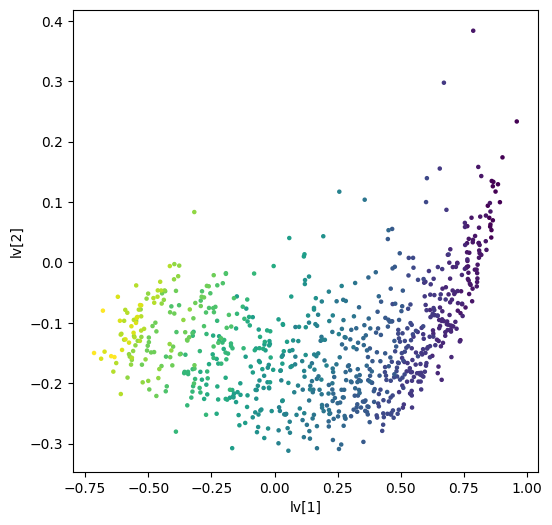

In [38]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(zs[index_slice,1], zs[index_slice,2],
           c=parameters[0][index_slice],
           s=5)
ax.set_xlabel('lv[1]')
ax.set_ylabel('lv[2]')

scatter_name = './figures_SQ_cVAE_MSE_ns/lvsc3D_eta.png'
# plt.savefig(scatter_name.format(epoch))
plt.show()

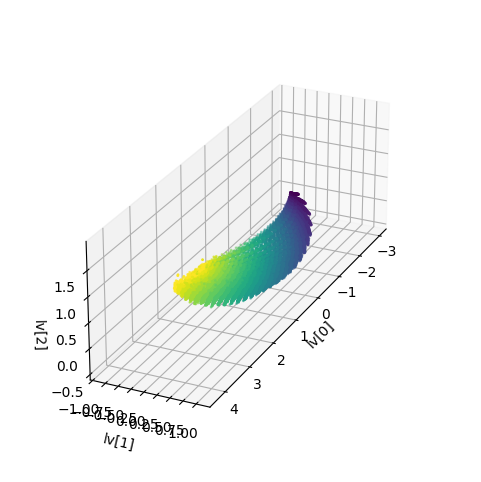

In [39]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
           c=parameters[0][index_eta],
           s=1)
ax.view_init(elev=25, azim=25)
ax.set_xlabel('lv[0]')
ax.set_ylabel('lv[1]')
ax.set_zlabel('lv[2]')
ax.set_box_aspect([d_zs[0],d_zs[1],d_zs[2]])

scatter_name = '../Figures/lvsc3D_eta.png'
plt.savefig(scatter_name, dpi=300)
plt.show()

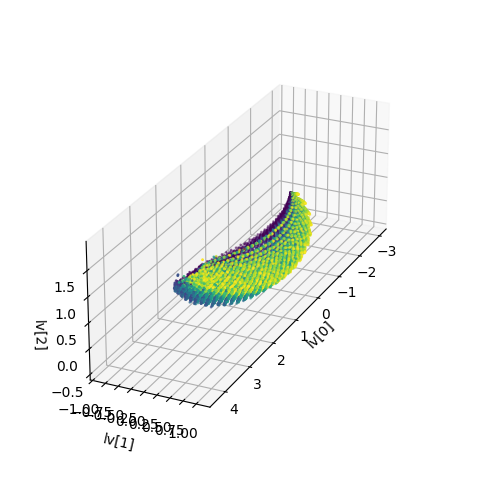

In [40]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
           c=parameters[1][index_eta],
           s=1)
ax.view_init(elev=25, azim=25)
ax.set_xlabel('lv[0]')
ax.set_ylabel('lv[1]')
ax.set_zlabel('lv[2]')
ax.set_box_aspect([d_zs[0],d_zs[1],d_zs[2]])

scatter_name = '../Figures/lvsc3D_kappa.png'
plt.savefig(scatter_name, dpi=300)
plt.show()

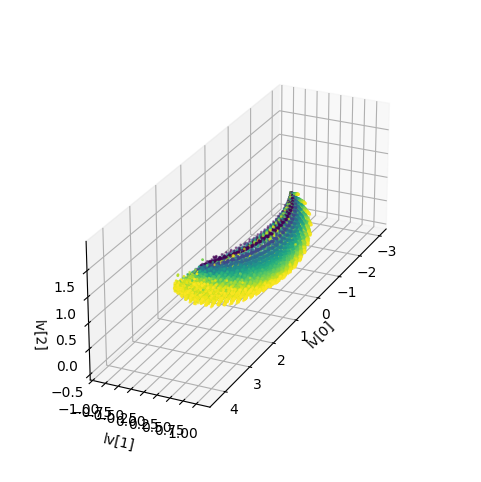

In [41]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
           c=parameters[2][index_eta],
           s=1)
ax.view_init(elev=25, azim=25)
ax.set_xlabel('lv[0]')
ax.set_ylabel('lv[1]')
ax.set_zlabel('lv[2]')
ax.set_box_aspect([d_zs[0],d_zs[1],d_zs[2]])

scatter_name = '../Figures/lvsc3D_lnA.png'
plt.savefig(scatter_name, dpi=300)
plt.show()

## Visualize latent space

In [42]:
%matplotlib inline

In [65]:
def plot_latent_images_SVD(model, n, axis_0, axis_1):
    axis_2 = np.setdiff1d(np.arange(3),np.array([axis_0, axis_1]))[0]
    
    n_std = 4
    
    if 1:
        grid_0 = (np.arange(n)*(n_std*2/(n-1))-n_std)*np.std(zs[:,axis_0])+np.mean(zs[:,axis_0])
        grid_1 = (np.arange(n)*(n_std*2/(n-1))-n_std)*np.std(zs[:,axis_1])+np.mean(zs[:,axis_1])
        grid_2 = (np.arange(n)*(n_std*2/(n-1))-n_std)*np.std(zs[:,axis_2])+np.mean(zs[:,axis_2])
        
    # color
    p_c = parameters[2]
    
    zi = 0
    fig = plt.figure(figsize=(n, n))
    fig.subplots_adjust(wspace = 0,hspace = 0)
    for i, xi in enumerate(grid_0):
        for j, yi in enumerate(grid_1):
            zs_normal = np.array([[xi, yi, grid_2[int((n-1)/2)]]])
            zc_normal = np.matmul(zs_normal,U.T)
            z_normal = zc_normal+z_mean
#             logvar_grid = np.log(np.var(zs,axis=0))-2*np.log((6/(n-1)))
#             zr = model.reparameterize(z_normal, logvar_grid)
            x_decoded = model.sample(z_normal)
            sq_ij = f_out(x_decoded)
            index_fig = n*(n-j-1)+i+1
            
            ax = fig.add_subplot(n, n, index_fig)
            
            index_exist_x = ((zs[:,axis_0]>=xi-np.std(zs[:,axis_0])/(n-1)*n_std*2)&
                             (zs[:,axis_0]<xi+np.std(zs[:,axis_0])/(n-1)*n_std*2))
            index_exist_y = ((zs[:,axis_1]>=yi-np.std(zs[:,axis_1])/(n-1)*n_std*2)&
                             (zs[:,axis_1]<yi+np.std(zs[:,axis_1])/(n-1)*n_std*2))
            index_exist_z = ((zs[:,axis_2]>=zi-np.std(zs[:,axis_2])/(n-1)*n_std*2)&
                             (zs[:,axis_2]<zi+np.std(zs[:,axis_2])/(n-1)*n_std*2))
            
            if any(index_exist_x&index_exist_y):
                if np.mean(index_exist_z[index_exist_x&index_exist_y==1])>0.125:
                    p_c_ave = np.mean(p_c[index_exist_x&index_exist_y&index_exist_z])
                    x_c = (p_c_ave-min(p_c))/(max(p_c)-min(p_c))
                    color = plt.get_cmap('viridis')(x_c)
                    plt.plot(q_rs[3:],sq_ij[0,3:],color=color)
                    ax.set_facecolor('k')
                    ax.tick_params(axis='x', colors='w')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('w')
#                     plt.text(0,0,'{:.2f}'.format(p_c_ave),color='w')
                else:
                    plt.plot(q_rs[3:],sq_ij[0,3:],'k')
            else:
                plt.plot(q_rs[3:],sq_ij[0,3:],'k')
            plt.ylim(0, 3)
            plt.gca().axes.get_xaxis().set_ticklabels([])
            plt.gca().axes.get_yaxis().set_ticks([])
#             plt.text(0,0,'{:.2f}'.format(yi))
            ax.tick_params(direction='in')

    plt.show()

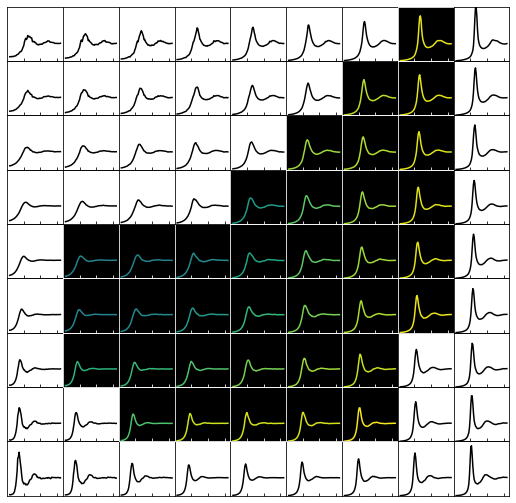

In [66]:
plot_latent_images_SVD(model, n=9, axis_0=1, axis_1=2)

#### 